## 1. Transfer Learning for CNNs

In [1]:
import numpy as np

import torch

import torchvision
from torchvision.models.vgg import vgg11, vgg11_bn
from torchvision.models.resnet import resnet18, resnet34
from torchvision.models.densenet import densenet121
from torchvision.models.mobilenetv3 import mobilenet_v3_small

import matplotlib.pyplot as plt

### Question 1.1

a) (4 points) Plot for VGG11, VGG11 with batch normalization, ResNet18,
ResNet34, DenseNet121 and MobileNet-v3-Small, the Top-1 accuracy on ImageNet
vs the inference speed. The value for the Top-1 accuracy of each model can be
found on the PyTorch website. Also plot the inference speed vs the number
of parameters. Does it scale proportionately? Make sure to set the model on
evaluation mode, use torch.no_grad() and a GPU. Report the inference
speed in ms for one image. Average the inference speed across multiple forward
passes. Shortly, describe the trends you observe.

b) (2 points) Do you expect the inference speed to increase or decrease without
torch.no_grad()? Why? What does torch.no_grad() do? For the same
models as in (a), plot the inference speed with and without torch.no_grad().

c) (2 points) For the same models as in (a), plot the amount of GPU vRAM (you
can check this with code by executing torch.cuda.memory_allocated()
or with the terminal using nvidia-smi) while conducting a forward pass
with torch.no_grad() and without. Does torch.no_grad() influence the
memory usage? Why? Make sure to save the output after the forward pass. Use
batch_size=64 and report the memory in MB.

In [2]:
# Set seed
seed = 14334739
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}')
print()

# Generate fake dataset
M = 256  # Image count (Number of forward passes)
N = 32  # Image height/width
torch.manual_seed(14334739)
test_images = torch.rand((M, 3, N, N))

# Select pre-trained models
model_list = ['VGG11', 'VGG11 with BatchNorm', 'ResNet18', 'ResNet34', 'DenseNet121', 'MobileNet-v3-Small']

GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU



In [3]:
def eval_models(model_list, test_images, batch_size, no_grad=True):

    # Create dataloader
    test_loader = [test_images[i*batch_size:(i+1)*batch_size,:,:] for i in range(int(test_images.shape[0] / batch_size))]

    # Metric lists
    acc_list = [69.02, 70.37, 69.758, 73.314, 74.434, 67.668]  # From https://pytorch.org/vision/stable/models.html
    time_list = []
    param_list = []
    memory_list = []

    # Events for time calculation
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Evaluate models
    print('Evaluating models...')
    for i, model_label in enumerate(model_list):  # For each model

        if model_label == 'VGG11':
            model = vgg11()
        elif model_label == 'VGG11 with BatchNorm':
            model = vgg11_bn()
        elif model_label == 'ResNet18':
            model = resnet18()
        elif model_label == 'ResNet34':
            model = resnet34()
        elif model_label == 'DenseNet121':
            model = densenet121()
        elif model_label == 'MobileNet-v3-Small':
            model = mobilenet_v3_small()

        # Send model to GPU and switch to eval mode
        model.to(device)
        model.eval()

        print(f'   {model_list[i]}')
        model_time_list = []  # Inference time calculations for the model

        # GPU Warm-up
        warm_up_input = torch.rand((1,3,N,N)).to(device)
        for i in range(100):
            if no_grad:
                with torch.no_grad():
                    warm_up_predictions = model(warm_up_input)
            else:
                warm_up_predictions = model(warm_up_input)

        for inputs in test_loader:  # For each batch (This implements the multiple forward passes we want)

            # Send data to GPU
            inputs = inputs.to(device)

            # Test model
            start.record()
            if no_grad:
                with torch.no_grad():
                    predictions = model(inputs)
            else:
                predictions = model(inputs)
            end.record()

            # Append metric calculations to list
            torch.cuda.synchronize()  # For accurate time calculation
            model_time_list.append(start.elapsed_time(end) / batch_size)  # Inference time in milliseconds for one image


        # Get model metrics
        time_list.append(np.mean(model_time_list))
        param_list.append(sum(p.numel() for p in model.parameters()) / 10**6)  # Count model parameters in millions
        memory_list.append(torch.cuda.memory_allocated() / 2**20)

        # Free GPU cache after every model
        predictions.detach()
        del model
        del predictions
        torch.cuda.empty_cache()

    return acc_list, time_list, param_list, memory_list

Evaluating models...
   VGG11
   VGG11 with BatchNorm
   ResNet18
   ResNet34
   DenseNet121
   MobileNet-v3-Small


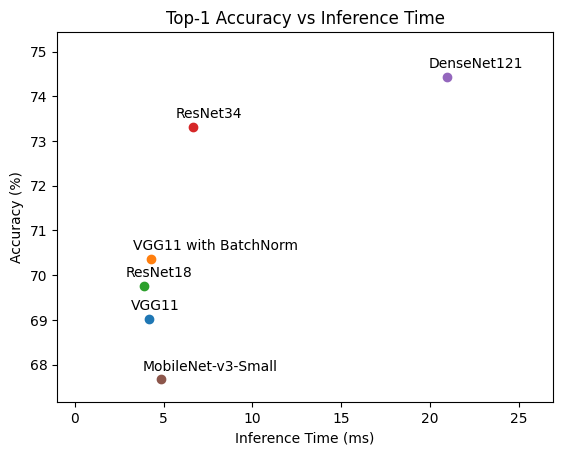

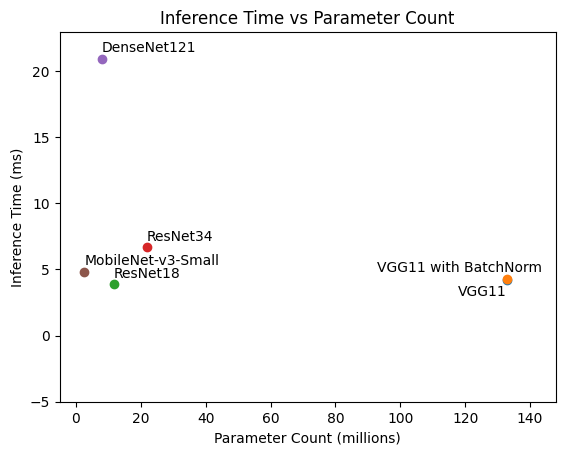

In [6]:
# Question 1.1.a

# Evaluate models
acc_list, time_list, param_list, _ = eval_models(model_list, test_images, batch_size=1, no_grad=True)

# Plot Accuracy vs Inference Time
plt.title('Top-1 Accuracy vs Inference Time')
plt.xlabel('Inference Time (ms)')
plt.ylabel('Accuracy (%)')
plt.xlim(-1, max(time_list) + 6)
plt.ylim(min(acc_list) - 0.5, max(acc_list) + 1)
for i in range(len(model_list)):
    plt.scatter(time_list[i], acc_list[i])
    plt.annotate(model_list[i], (time_list[i] - 1, acc_list[i] + 0.2))

plt.show()

# Plot Inference Time vs Parameter Count
plt.title('Inference Time vs Parameter Count')
plt.ylabel('Inference Time (ms)')
plt.xlabel('Parameter Count (millions)')
x_offset = [-15, -40, 0, 0, 0, 0]
y_offset = [-1.2, 0.5, 0.5, 0.5, 0.5, 0.5]
plt.xlim(-5, max(param_list) + 15)
plt.ylim(-5, max(time_list) + 2)
for i in range(len(model_list)):
    plt.scatter(param_list[i], time_list[i])
    plt.annotate(model_list[i], (param_list[i] + x_offset[i], time_list[i] + y_offset[i]))

plt.show()

Evaluating models...
   VGG11
   VGG11 with BatchNorm
   ResNet18
   ResNet34
   DenseNet121
   MobileNet-v3-Small


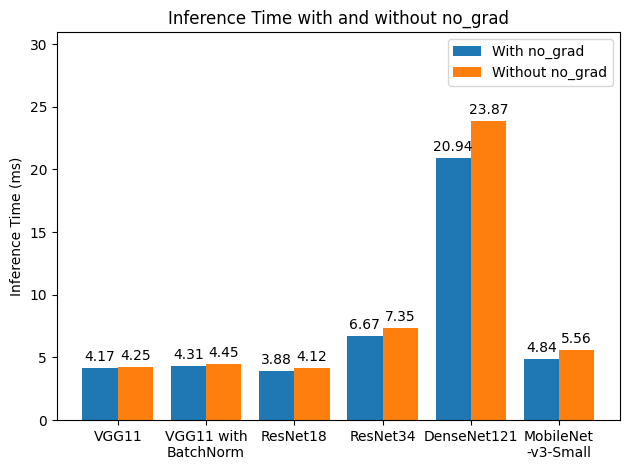

In [9]:
# Question 1.1.b

# Evaluate models
_, grad_time_list, _, _ = eval_models(model_list, test_images, batch_size=1, no_grad=False)  # Without no_grad

# Plot Inference Time with and without no_grad
x = np.arange(len(model_list))
width = 0.4
model_list_wrapped = ['VGG11', 'VGG11 with\nBatchNorm', 'ResNet18', 'ResNet34', 'DenseNet121', 'MobileNet\n-v3-Small']
fig, ax = plt.subplots()
ax.set_title('Inference Time with and without no_grad')
rects1 = ax.bar(x - width/2, np.round(time_list,2), width, label='With no_grad')
rects2 = ax.bar(x + width/2, np.round(grad_time_list,2), width, label='Without no_grad')
ax.set_ylabel('Inference Time (ms)')
ax.set_xticks(x, model_list_wrapped)
ax.set_ylim((0,max(time_list) + 10))
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()

plt.show()

Evaluating models...
   VGG11
   VGG11 with BatchNorm
   ResNet18
   ResNet34
   DenseNet121
   MobileNet-v3-Small
Evaluating models...
   VGG11
   VGG11 with BatchNorm
   ResNet18
   ResNet34
   DenseNet121
   MobileNet-v3-Small


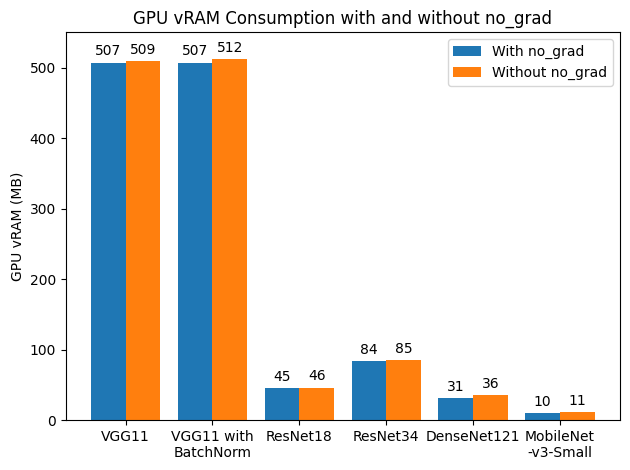

In [8]:
# Question 1.1.c

# Evaluate models
_, _, _, memory_list = eval_models(model_list, test_images, batch_size=1, no_grad=True)  # With batch_size=64 and with no_grad
_, _, _, grad_memory_list = eval_models(model_list, test_images, batch_size=1, no_grad=False)  # With batch_size=64 and without no_grad

# Plot GPU vRAM Consumption with and without no_grad
x = np.arange(len(model_list))
width = 0.4
model_list_wrapped = ['VGG11', 'VGG11 with\nBatchNorm', 'ResNet18', 'ResNet34', 'DenseNet121', 'MobileNet\n-v3-Small']
fig, ax = plt.subplots()
ax.set_title('GPU vRAM Consumption with and without no_grad')
rects1 = ax.bar(x - width/2, np.round(memory_list), width, label='With no_grad')
rects2 = ax.bar(x + width/2, np.round(grad_memory_list), width, label='Without no_grad')
ax.set_ylabel('GPU vRAM (MB)')
ax.set_xticks(x, model_list_wrapped)
ax.set_ylim((0,550))
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()

plt.show()